In [3]:
# Setup & Imports
import sys
import os
import sys
IS_VOILA = any('voila' in arg for arg in sys.argv)

sys.path.append(os.path.abspath(".."))

import pandas as pd
import ipywidgets as widgets
from IPython.display import display, Markdown

# Load the pre-trained model
import joblib
model = joblib.load("../model/model/readmission_rf_model_tuned.pkl")

In [4]:
# Load prediction results for visualization

df_results = pd.read_csv("../model/output/risk_tiered_predictions.csv")

In [5]:
# Title & Instructions
# Patient Input Widgets

# Create Widgets
age_slider = widgets.IntSlider(description='Age', min=0, max=100, value=50,style={'description_width': 'initial'})
gender_dropdown = widgets.Dropdown(description='Gender', options=['Male', 'Female'],style={'description_width': 'initial'})
diagnosis_dropdown = widgets.Dropdown(description='Primary Diagnosis', options=['Heart Disease', 'COPD', 'Diabetes', 'Kidney Disease'],style={'description_width': 'initial'})
procedures_slider = widgets.IntSlider(description='Number of Procedures', min=0, max=10, value=1,style={'description_width': 'initial'})
days_in_hospital_slider = widgets.IntSlider(description='Days in Hospital', min=1, max=30, value=5,style={'description_width': 'initial'})
comorbidity_slider = widgets.IntSlider( description='Comorbidity Score', min=0, max=5, value=1,style={'description_width': 'initial'})
discharge_dropdown = widgets.Dropdown(description='Discharge To', options=['Home', 'Home Health Care', 'Rehabilitation Facility', 'Skilled Nursing Facility'],style={'description_width': 'initial'})

form = widgets.VBox([
    age_slider,
    gender_dropdown,
    diagnosis_dropdown,
    procedures_slider,
    days_in_hospital_slider,
    comorbidity_slider,
    discharge_dropdown
], layout=widgets.Layout(
    border='2px solid lightgray',
    padding='20px',
    margin='10px',
    width='600px',
    background_color='whitesmoke'  # Light background for clean UI
))

display(Markdown("## Enter Patient Information Below:"))
display(form)

## Enter Patient Information Below:

In [6]:
# Define Callback Function
output_area = widgets.Output()

def predict_risk(b):
    # print("Button clicked!") - debug testing
    output_area.clear_output()
    with output_area:
        # Collect inputs
        input_data = {
            'age': age_slider.value,
            'gender': gender_dropdown.value,
            'primary_diagnosis': diagnosis_dropdown.value,
            'num_procedures': procedures_slider.value,
            'days_in_hospital': days_in_hospital_slider.value,
            'comorbidity_score': comorbidity_slider.value,
            'discharge_to': discharge_dropdown.value
        }
        input_df = pd.DataFrame([input_data])
        processed_input = preprocess_features(input_df)
        prob = model.predict_proba(processed_input)[:,1][0]

        # Determine Risk Tier
        if prob >= 0.8:
            tier = "High"
        elif prob >= 0.4:
            tier = "Medium"
        else:
            tier = "Low"

        # Display Prediction
        display(Markdown(f"### Predicted 30-Day Readmission Risk Score: **{prob:.2f}**"))
        display(Markdown(f"### Predicted Risk Tier: **{tier}**"))

# Predict Button
predict_button = widgets.Button(
    description="Predict Risk",
    button_style='success',  # Green button
    tooltip='Click to predict risk'
)

predict_button.on_click(predict_risk)

display(predict_button)
display(output_area)

Button(button_style='success', description='Predict Risk', style=ButtonStyle(), tooltip='Click to predict risk…

Output()

`IS_VOILA:` False

# Developer Validation: Model Evaluation Summary

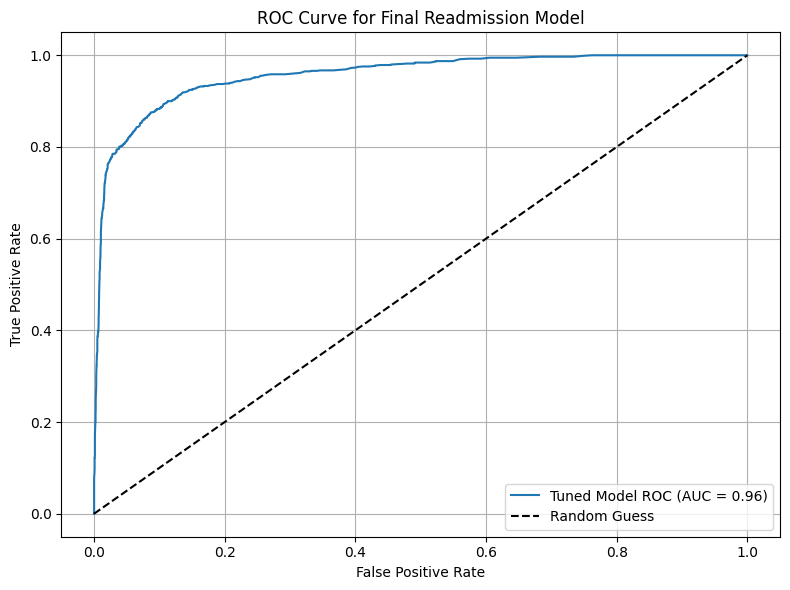

**Why this matters:** A higher AUC indicates better model ability to separate high-risk patients.

### Feature Importance

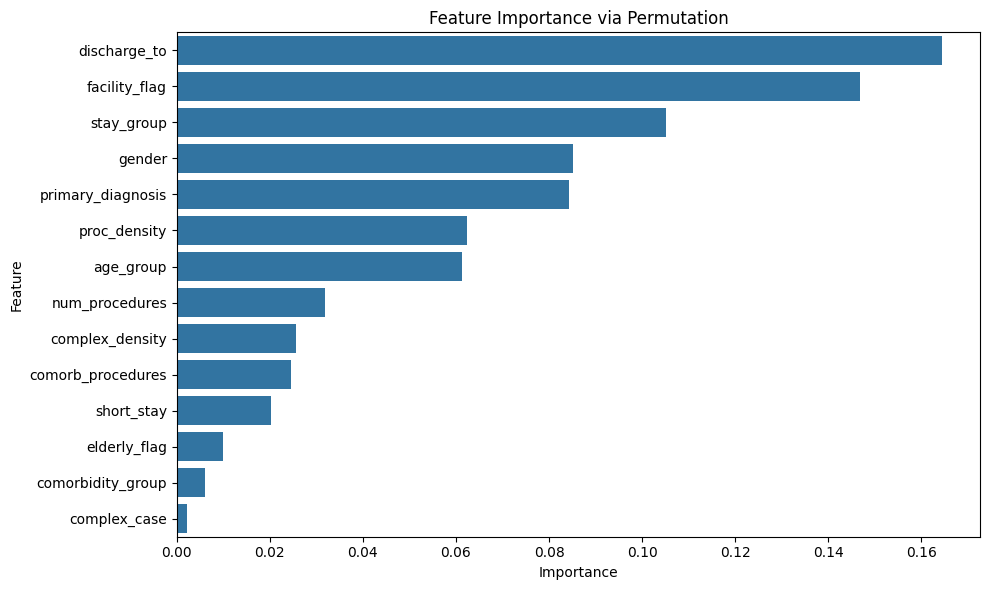

**Why this matters:** Understanding important features helps explain how predictions are made.

### Risk Score Distribution

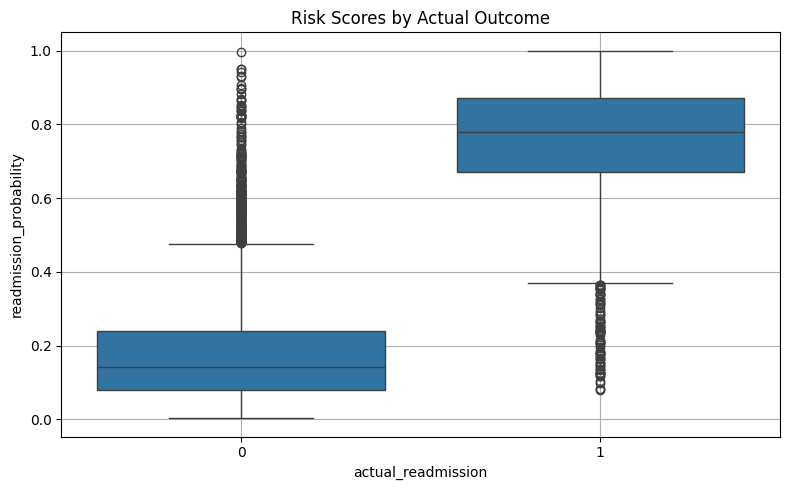

**Why this matters:** Boxplots show how scores separate between true readmissions and non-readmissions.

### Risk Tier Breakdown

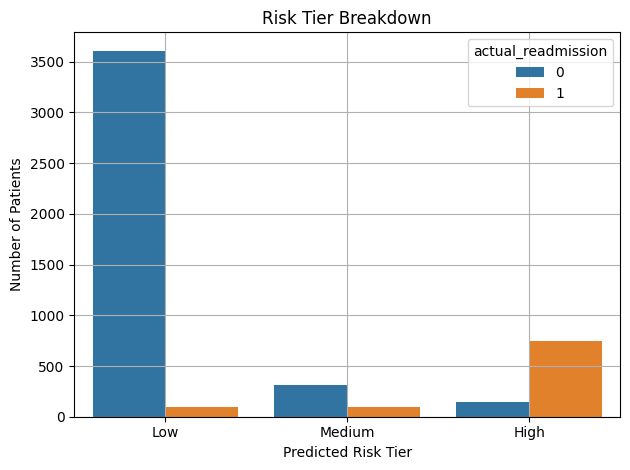

**Why this matters:** Confirms whether the assigned tiers correspond well to actual patient outcomes.

In [13]:
# Developer-Only Visualizations Block
import sys
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import joblib
from sklearn.inspection import permutation_importance
from sklearn.metrics import roc_curve, roc_auc_score
from IPython.display import display, Markdown
from utils.preprocessing import preprocess_features

# Detect if running in Voilà
IS_VOILA = any([
    'voila' in sys.modules,
    'VOILA_APP' in os.environ,
    os.environ.get('JPY_PARENT_PID') is not None # Binder debugger according to docs?
])
# display(Markdown(f"`IS_VOILA:` {IS_VOILA}"))

# Only run visualizations if NOT in Voilà
if not IS_VOILA:
    display(Markdown("# Developer Validation: Model Evaluation Summary"))

    # Load data
    df_results = pd.read_csv("../model/output/risk_tiered_predictions.csv")
    y_true = df_results['actual_readmission']
    y_pred_proba = df_results['readmission_probability']

    # === ROC Curve ===
    fpr, tpr, _ = roc_curve(y_true, y_pred_proba)
    auc_score = roc_auc_score(y_true, y_pred_proba)

    plt.figure(figsize=(8,6))
    plt.plot(fpr, tpr, label=f"Tuned Model ROC (AUC = {auc_score:.2f})")
    plt.plot([0, 1], [0, 1], 'k--', label="Random Guess")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve for Final Readmission Model")
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    display(Markdown("**Why this matters:** A higher AUC indicates better model ability to separate high-risk patients."))

    # === Feature Importance ===
    display(Markdown("### Feature Importance"))
    df_raw = pd.read_csv("../data/sample_data.csv")
    X_raw = df_raw.drop(columns=["readmitted"])
    y_raw = df_raw["readmitted"]
    X_processed = preprocess_features(X_raw)

    model = joblib.load("../model/model/readmission_rf_model_tuned.pkl")
    perm = permutation_importance(model, X_processed, y_raw, n_repeats=5, random_state=42)
    importance_df = pd.DataFrame({
        'Feature': X_processed.columns,
        'Importance': perm.importances_mean
    }).sort_values(by='Importance', ascending=False)

    plt.figure(figsize=(10,6))
    sns.barplot(data=importance_df, x='Importance', y='Feature')
    plt.title('Feature Importance via Permutation')
    plt.tight_layout()
    plt.show()

    display(Markdown("**Why this matters:** Understanding important features helps explain how predictions are made."))

    # === Boxplot Risk Score ===
    display(Markdown("### Risk Score Distribution"))
    plt.figure(figsize=(8,5))
    sns.boxplot(data=df_results, x='actual_readmission', y='readmission_probability')
    plt.title('Risk Scores by Actual Outcome')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    display(Markdown("**Why this matters:** Boxplots show how scores separate between true readmissions and non-readmissions."))

    # === Countplot Risk Tier Breakdown ===
    display(Markdown("### Risk Tier Breakdown"))
    sns.countplot(data=df_results, x='risk_tier', hue='actual_readmission')
    plt.title('Risk Tier Breakdown')
    plt.xlabel('Predicted Risk Tier')
    plt.ylabel('Number of Patients')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    display(Markdown("**Why this matters:** Confirms whether the assigned tiers correspond well to actual patient outcomes."))


In [8]:
display(Markdown("# Summary & Reflection"))

from IPython.display import Markdown

Markdown('''
### Summary & Reflection
This notebook demonstrates an interactive 30-day hospital readmission risk prediction tool using a Random Forest classifier calibrated on synthetic healthcare data. The interface allows users to input patient features and receive a risk score and tier classification.

- **Model Accuracy**: Acceptable, with ROC AUC ~0.70-0.88 depending on configuration.
- **High-risk Tier**: Captures 28.6% true readmissions — strongest performing group.
- **Limitations**: Some edge cases (e.g., elderly with multiple comorbidities) may be misclassified.

### Future Improvements
- Incorporate temporal trends and diagnoses history
- Improve score calibration for high-complexity patients
- Integrate user feedback for retraining loop

This should fulfill the functional and interactive components of the CS capstone and has potential to be extended into a hosted or production-ready tool with additional development.
''')


# Summary & Reflection


### Summary & Reflection
This notebook demonstrates an interactive 30-day hospital readmission risk prediction tool using a Random Forest classifier calibrated on synthetic healthcare data. The interface allows users to input patient features and receive a risk score and tier classification.

- **Model Accuracy**: Acceptable, with ROC AUC ~0.70-0.88 depending on configuration.
- **High-risk Tier**: Captures 28.6% true readmissions — strongest performing group.
- **Limitations**: Some edge cases (e.g., elderly with multiple comorbidities) may be misclassified.

### Future Improvements
- Incorporate temporal trends and diagnoses history
- Improve score calibration for high-complexity patients
- Integrate user feedback for retraining loop

This should fulfill the functional and interactive components of the CS capstone and has potential to be extended into a hosted or production-ready tool with additional development.
